In [2]:
#Loading needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
#library("themis")
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
#Load dataset into Jupyter
ccData <- read_excel('data/default-cc-data.xls')  
head(ccData)

New names:
* `` -> ...1



...1,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#Tidy data by 
#  taking out columns on Education, marriage and payments, 
#  renaming the columns, 
#  slicing out top two rows, 
#  Changing data types from character to numeric for all columns except for default status
#  Changing the values for default_status to yes/no to make it readable
#  Creating new columns that have the ratio debt to balance limit for each month across all rows*
#
#
#
#Our hypothesis is that people with higher debt loads, that is the amount of debt they have relative to their balance limit, 
#  and whose debt load increases over time, are more likely to default. That is why we are creating new colums that have the
#  debt to limit ratio and using these as our predictor. 

clean_ccData = ccData %>%
    select(-c(X2:X11))%>% 
    rename(client_id = "...1", 
           limit_bal = X1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
           default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
           default_status = as.factor(default_status),
           apr_debt_ratio = april_bill/limit_bal,
           may_debt_ratio = may_bill/limit_bal,
           jun_debt_ratio = june_bill/limit_bal,
           jul_debt_ratio = july_bill/limit_bal,
           aug_debt_ratio = aug_bill/limit_bal,
           sep_debt_ratio = sep_bill/limit_bal) %>%
    select(client_id, limit_bal, default_status, sep_debt_ratio : apr_debt_ratio)

head(clean_ccData)

client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,yes,0.1956500,0.1551000,0.0344500,0.00000000,0.00000000,0.0000000
2,120000,yes,0.0223500,0.0143750,0.0223500,0.02726667,0.02879167,0.0271750
3,90000,no,0.3248778,0.1558556,0.1506556,0.15923333,0.16608889,0.1727667
4,50000,no,0.9398000,0.9646600,0.9858200,0.56628000,0.57918000,0.5909400
5,50000,no,0.1723400,0.1134000,0.7167000,0.41880000,0.38292000,0.3826200
6,50000,no,1.2880000,1.1413800,1.1521600,0.38788000,0.39238000,0.4004800


In [5]:
#Split data into trainig and testing
debt_split = initial_split(clean_ccData, prop = 0.75, strata = default_status)
debt_train = training(debt_split)
debt_test = testing(debt_split)

`summarise()` ungrouping output (override with `.groups` argument)



default_status,n,percentage
<fct>,<int>,<dbl>
no,17523,77.88
yes,4977,22.12


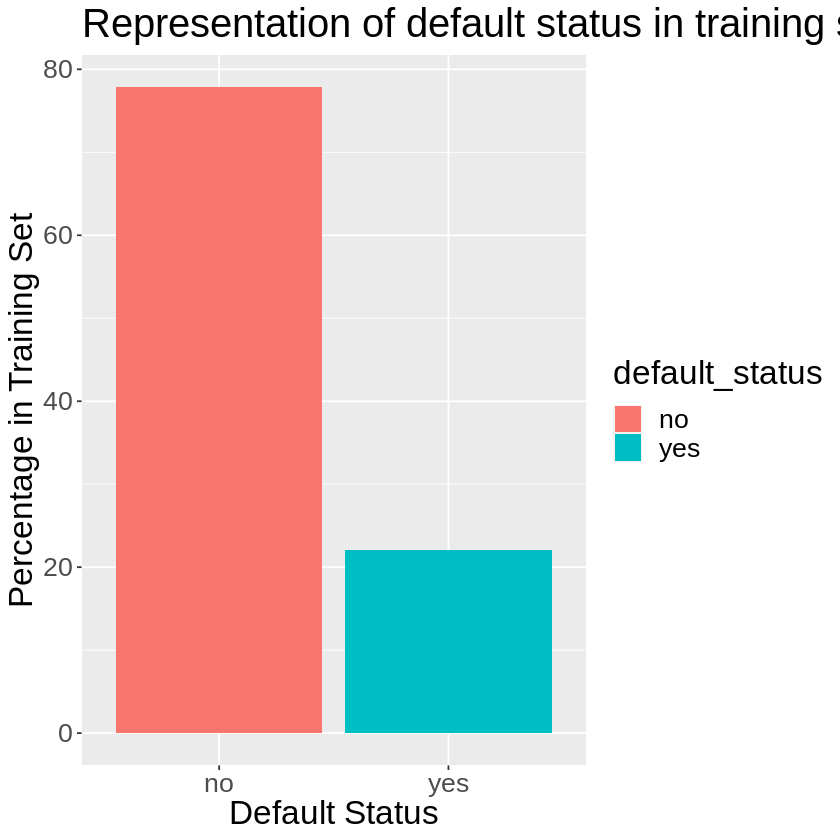

In [6]:
#Checking whether the training data is balanced or not. 
balance_count = debt_train %>%
    group_by(default_status) %>%
    summarize(n=n()) %>%
    mutate(percentage = n/nrow(debt_train)*100)
balance_count

plot_count = balance_count %>%
    ggplot(aes(x=default_status, y=percentage, fill=default_status)) +
    geom_bar(stat="identity") +
    labs(x="Default Status", 
         y="Percentage in Training Set", 
         color="Default Status", 
         title="Representation of default status in training set") +
    theme(text = element_text(size=20))
plot_count

In [7]:
# this is a table of the information we have for each observation
default_pivot <- debt_train %>% 
select(client_id, limit_bal, default_status, apr_debt_ratio:sep_debt_ratio) %>% 
 pivot_longer(cols = apr_debt_ratio:sep_debt_ratio,
                 names_to = "month",
                 values_to = "debt_ratio")
head(default_pivot)

client_id,limit_bal,default_status,month,debt_ratio
<chr>,<dbl>,<fct>,<chr>,<dbl>
1,20000,yes,apr_debt_ratio,0.00000
1,20000,yes,may_debt_ratio,0.00000
1,20000,yes,jun_debt_ratio,0.00000
1,20000,yes,jul_debt_ratio,0.03445
1,20000,yes,aug_debt_ratio,0.15510
1,20000,yes,sep_debt_ratio,0.19565


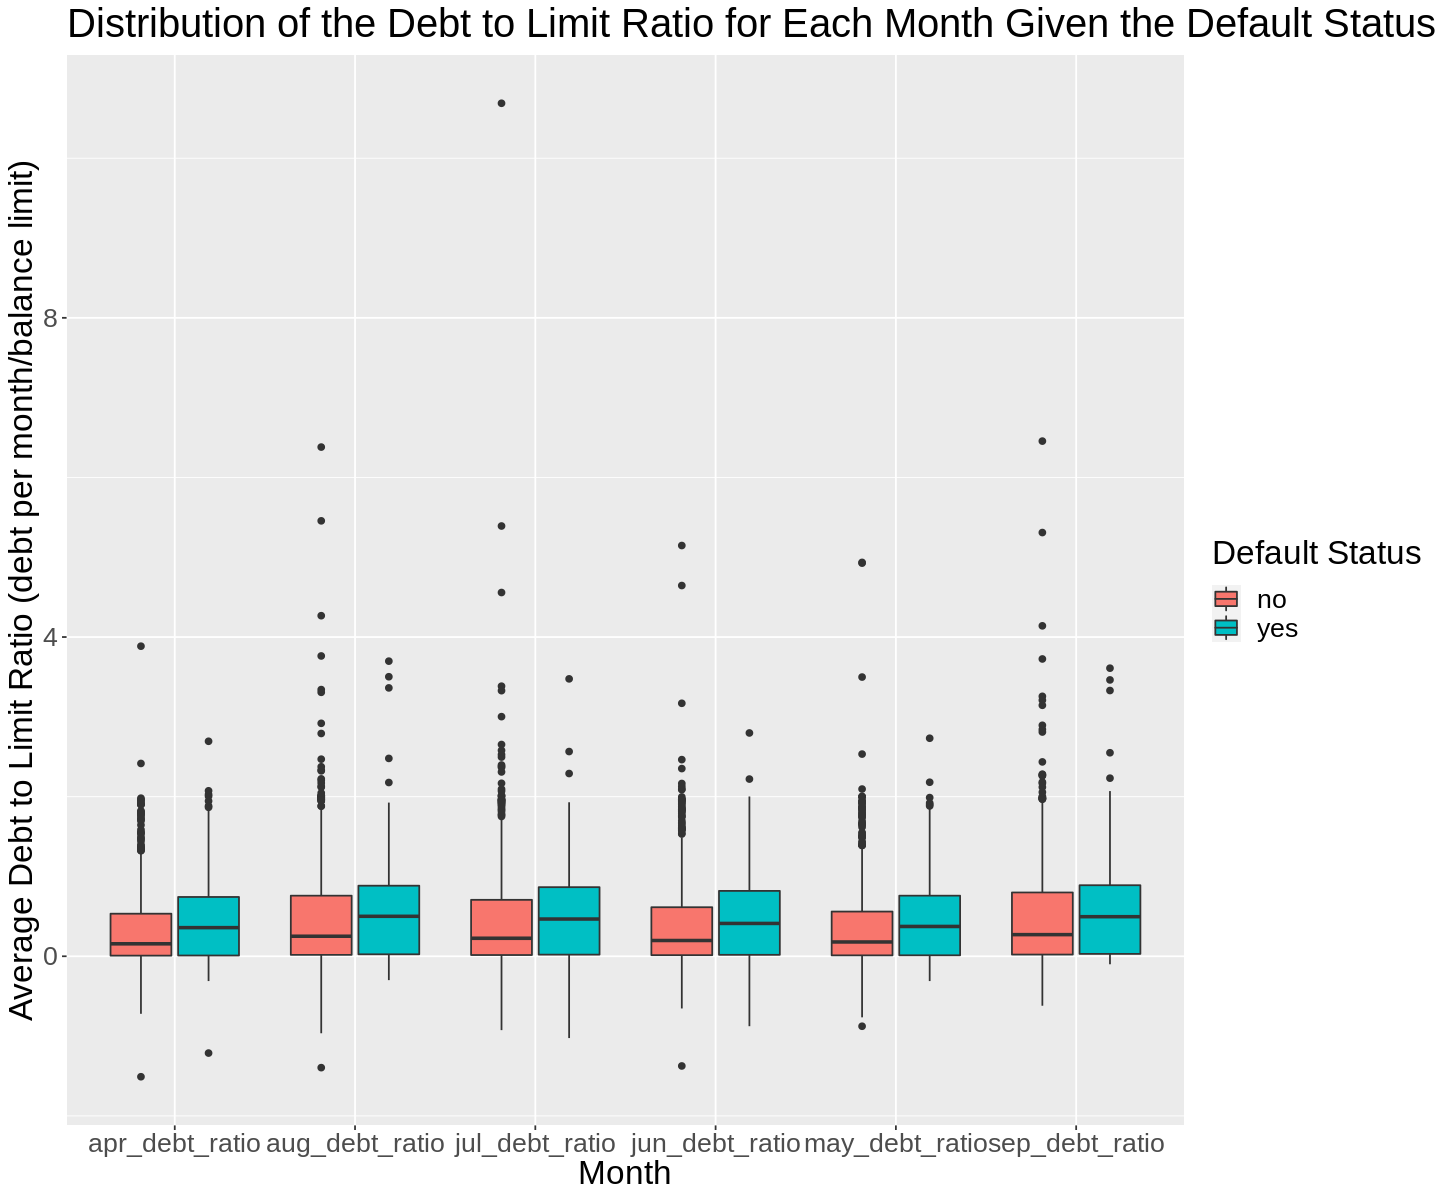

In [8]:
#Boxplot displaying the different the debt ratio distribution between people who defaulted and those who didn't
#TODO -- change labels for month
options(repr.plot.width = 12, repr.plot.height = 10)
debt_boxplot <- default_pivot %>% 
    ggplot(aes(y = debt_ratio, x = month, fill = default_status)) +
    geom_boxplot()+
    labs(y = "Average Debt to Limit Ratio (debt per month/balance limit)", x = "Month", fill = "Default Status") +
    ggtitle("Distribution of the Debt to Limit Ratio for Each Month Given the Default Status") +
    theme(text = element_text(size=20))
debt_boxplot

Since our theory is that people who have higher debt load and whose debt is increasing month to month, we need to see if there is an overall difference in debt load between those who defaulted and those who didn't. To test this, we are taking the average debt load for each group every available month and seeing if there is a difference in average debt load and how it changes over time. This table shows these averages. 

In [9]:
#Since our theory is that people who have higher debt load and whose debt is increasing month to month, we need to see if there
#  is an overall difference in debt load between those who defaulted and those who didn't. To test this, we are taking the 
#  average debt load for each group every available month and seeing if there is a difference in average debt load and how it
#  changes over time. This table shows these averages. 

ratio_averages = debt_train %>%
    group_by(default_status) %>%
    summarize(apr_avg = mean(apr_debt_ratio),
              bmay_avg = mean(may_debt_ratio),
              cjun_avg = mean(jun_debt_ratio),
              djul_avg = mean(jul_debt_ratio),
              eaug_avg = mean(aug_debt_ratio),
              fsep_avg = mean(sep_debt_ratio)) %>%
    pivot_longer(cols = apr_avg:fsep_avg,
                 names_to = "Month",
                 values_to = "avg_debt_ratio")
ratio_averages

`summarise()` ungrouping output (override with `.groups` argument)



default_status,Month,avg_debt_ratio
<fct>,<chr>,<dbl>
no,apr_avg,0.2963724
no,bmay_avg,0.3112047
no,cjun_avg,0.3361439
no,djul_avg,0.3700840
no,eaug_avg,0.3897087
no,fsep_avg,0.4053941
yes,apr_avg,0.4020887
yes,bmay_avg,0.4152069
yes,cjun_avg,0.4428016


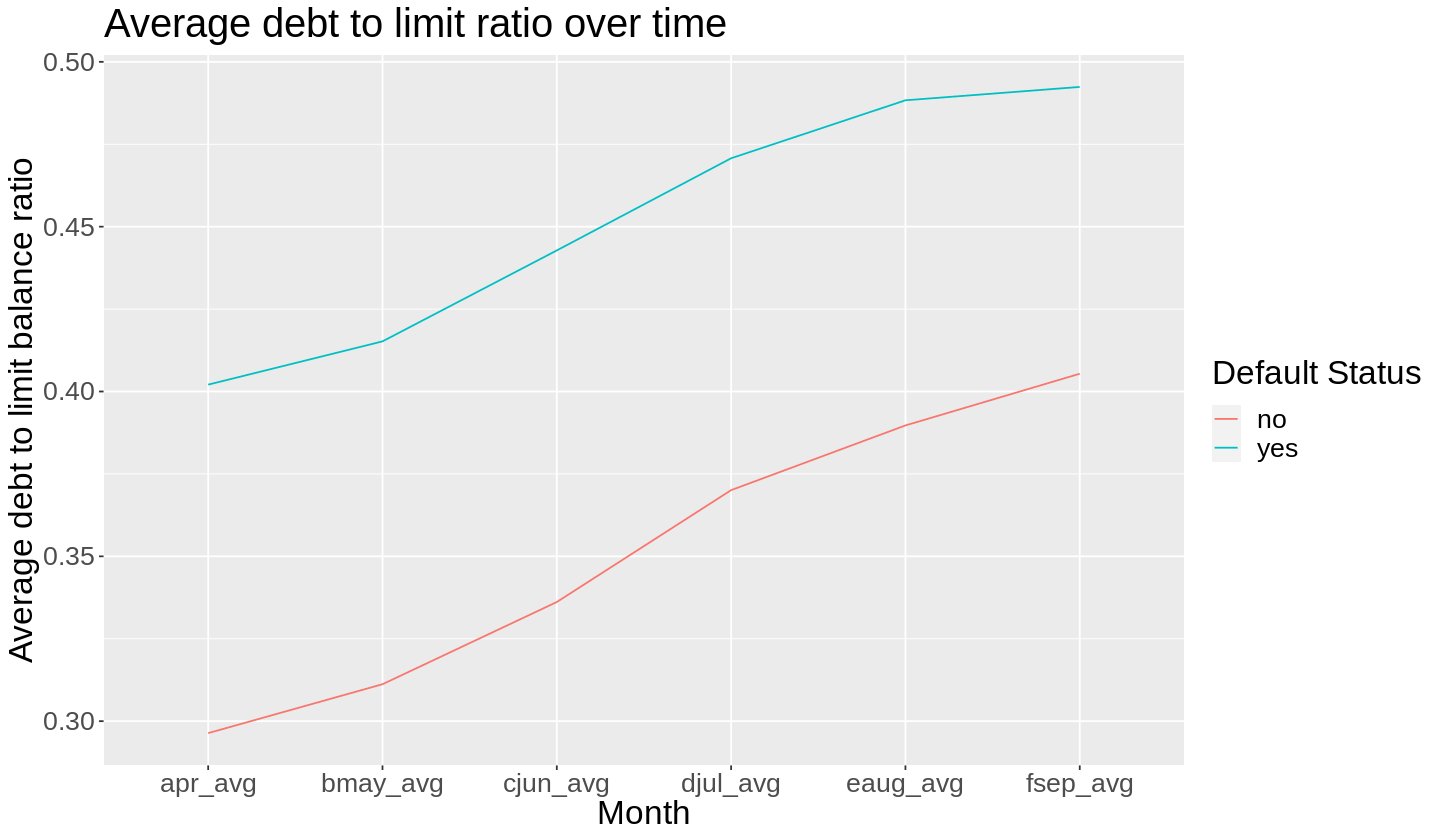

In [10]:
# Plot of the above table which plots the average debt load each month for both groups. 

# TODO --  change the labels for each month

options(repr.plot.width = 12, repr.plot.height = 7)
debt_ratio_plot = ratio_averages %>%
    ggplot(aes(x=Month, y=avg_debt_ratio, color=default_status)) +
    geom_line(data=ratio_averages, aes(group=default_status)) +
    labs(x="Month", 
         y="Average debt to limit balance ratio", 
         color="Default Status", 
         title="Average debt to limit ratio over time") +
    theme(text = element_text(size=20))
debt_ratio_plot

In [11]:
#Model recipe -- using upsample because training data is unbalanced with only 22% of people defaulting
debt_recipe = recipe(default_status ~ sep_debt_ratio + aug_debt_ratio 
                     + jul_debt_ratio + may_debt_ratio + apr_debt_ratio, data = debt_train) #%>%
#    step_upsample(default_status, over_ratio = 1, skip = FALSE) %>%
#    prep()
# TODO -- for some reason, the step upsample is not working with the workflow. Need to figure this out if we want to use upsampling

debt_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

In [12]:
debt_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
debt_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [24]:
# TODO: Commenting out so it doesn't take forever to run every time I reopen Jupyter. Make sure to uncomment for final version
debt_vfold = vfold_cv(debt_train, v=5, strata = default_status)

gridvals = tibble(neighbors = seq(1, 100, by = 5))

debt_results = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(debt_spec) %>%
    tune_grid(resamples = debt_vfold, grid = gridvals)%>%
    collect_metrics()
head(debt_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6859547,5,0.002524363,Model01
1,roc_auc,binary,0.5313089,5,0.003083955,Model01
6,accuracy,binary,0.7453775,5,0.001706871,Model02
6,roc_auc,binary,0.5923405,5,0.005679557,Model02
11,accuracy,binary,0.7645768,5,0.002794122,Model03
11,roc_auc,binary,0.6042289,5,0.004880507,Model03


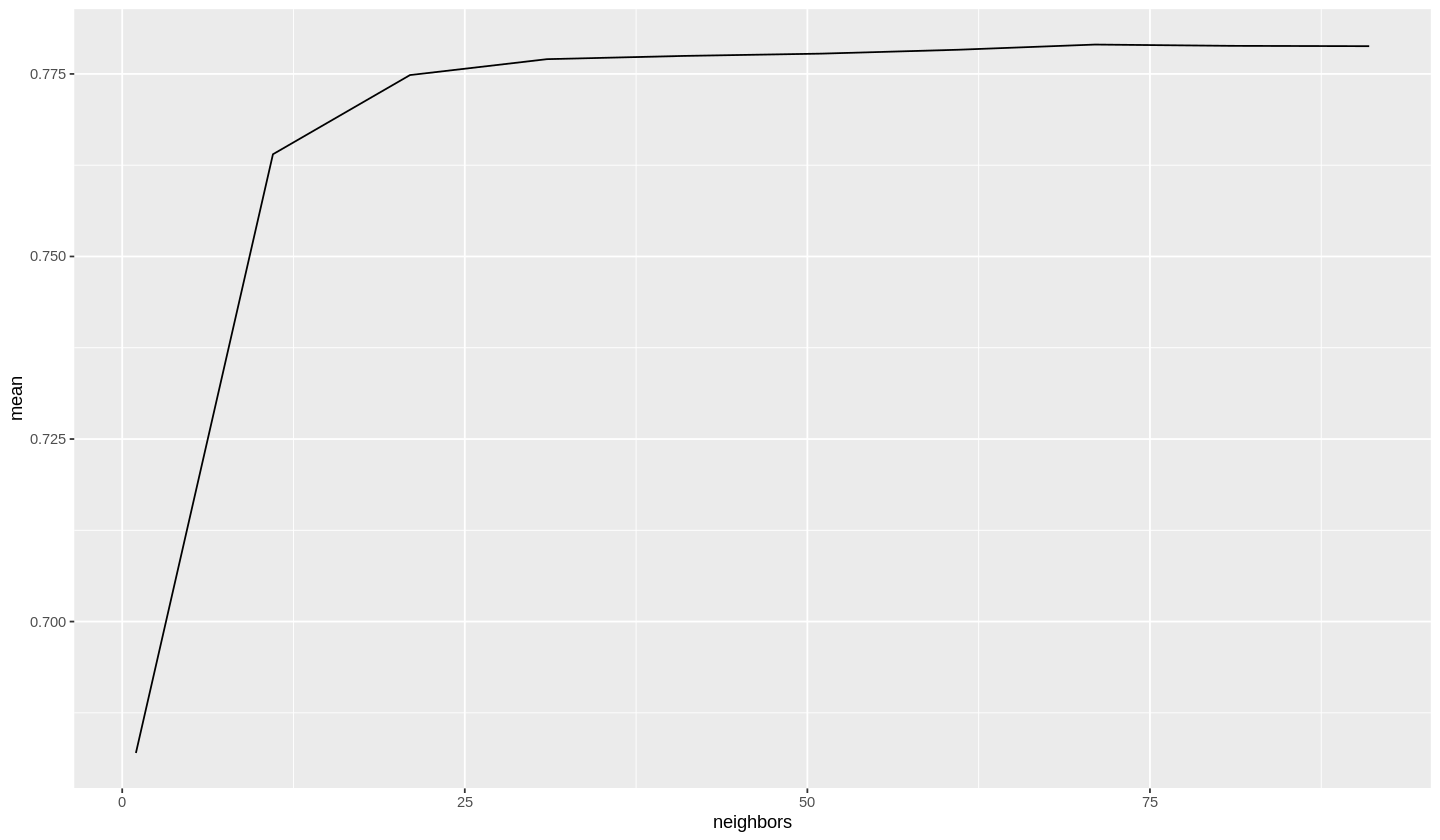

In [14]:
vfold_plot = debt_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_line()
vfold_plot


In [21]:
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 75) %>%
    set_engine("kknn") %>%
    set_mode("classification")

final_fit = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(final_spec) %>%
    fit(data = debt_train)
final_fit

debt_test_predictions = predict(final_fit, debt_test) %>%
    bind_cols(debt_test)
head(debt_test_predictions)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~75, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2213333
Best kernel: rectangular
Best k: 75

.pred_class,client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<fct>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,6,50000,no,1.28800000,1.14138000,1.15216000,0.38788000,0.39238000,0.400480000
no,11,200000,no,0.05536500,0.04893500,0.02767500,0.01256500,0.00914000,0.018655000
no,12,260000,no,0.04715769,0.08334615,0.03833077,0.03275769,0.08571923,0.052569231
no,13,630000,no,0.01926508,0.01031746,0.01031746,0.01031746,0.01031746,0.004555556
no,14,70000,yes,0.94002857,0.96241429,0.93858571,0.95402857,0.51624286,0.527057143
no,15,250000,no,0.28354800,0.26824000,0.25424400,0.23878400,0.22750000,0.222048000


In [25]:
accuracy = debt_test_predictions %>%
    metrics(truth = default_status, estimate = .pred_class) 

confidence = debt_test_predictions %>%
    conf_mat(truth = default_status, estimate = .pred_class)

accuracy
confidence

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.777733333
kap,binary,0.008507682


          Truth
Prediction   no  yes
       no  5817 1643
       yes   24   16

**Prediction visual**

Before we create our visual, we added a column to the predictions table stating if our model predicted correctly or incorrectly, and used pivot longer to have months as a variable in the prediction visual

In [17]:
debt_mutation <- debt_test_predictions %>% 
mutate(pred_results = ifelse((.pred_class == "yes") & (.pred_class == default_status), "true_pos", 
                             ifelse((.pred_class == "yes") & (.pred_class != default_status), "false_pos", 
                             ifelse((.pred_class == "no") & (.pred_class == default_status), "true_neg", 
                             ifelse((.pred_class == "no") & (.pred_class != default_status), "false_neg", NA))))) %>% 
pivot_longer(cols = apr_debt_ratio:sep_debt_ratio,
                 names_to = "month",
                 values_to = "debt_ratio")

head(debt_mutation)

.pred_class,client_id,limit_bal,default_status,pred_results,month,debt_ratio
<fct>,<chr>,<dbl>,<fct>,<chr>,<chr>,<dbl>
no,6,50000,no,true_neg,apr_debt_ratio,0.40048
no,6,50000,no,true_neg,may_debt_ratio,0.39238
no,6,50000,no,true_neg,jun_debt_ratio,0.38788
no,6,50000,no,true_neg,jul_debt_ratio,1.15216
no,6,50000,no,true_neg,aug_debt_ratio,1.14138
no,6,50000,no,true_neg,sep_debt_ratio,1.28800


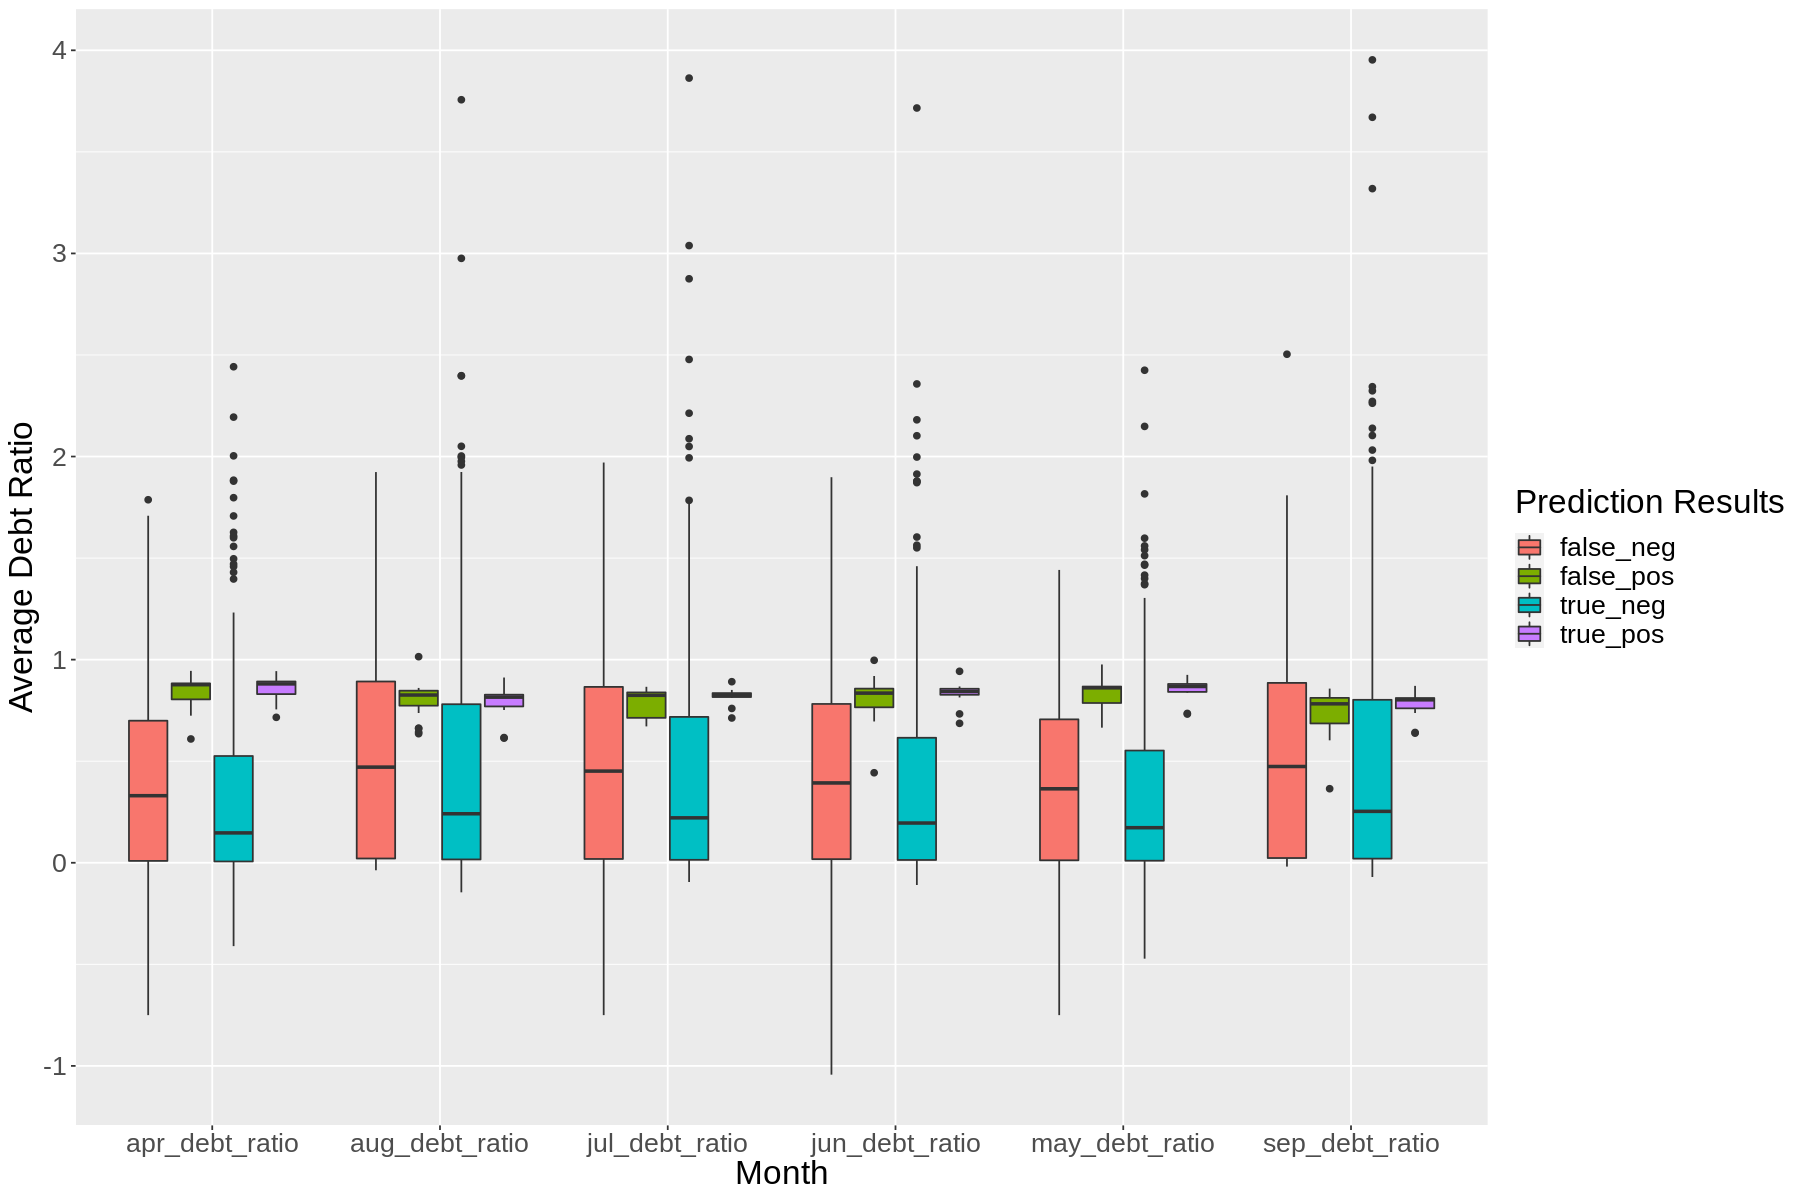

In [18]:
#TODO -- Add title 
#TODO -- Put the months in order (if poosible)
options(repr.plot.width = 15, repr.plot.height = 10)

prediction_plot <- debt_mutation %>% 
    ggplot(aes(y = debt_ratio, x = month, fill = pred_results)) +
    geom_boxplot()+
    labs(y = "Average Debt Ratio", x = "Month", fill = "Prediction Results") +
    theme(text = element_text(size=20))
prediction_plot